In [1]:
import jax
import jax.numpy as jnp

from flax import linen as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import wandb
from wandb.apis.public import Api

import time
from dataclasses import dataclass

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Setup

In [2]:
# Configuration
PROJECT_NAME = "induced_metric"
RUN_INDEX = 1  # Change this to analyze different run indices
ENTITY_NAME = "thomas_harvey" 

# Speedrun target accuracy losses
SPEEDRUN_TARGETS = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

# Optimizer names to analyze
OPTIMISERS = ['adam', 'adamw', 'sgd', 'sgd_metric', 'sgd_log_metric', 'muon', 'sgd_rms']

print(f"Analyzing run index: {RUN_INDEX}")
print(f"Project: {PROJECT_NAME}")
print(f"Optimisers: {OPTIMISERS}")
print(f"Speedrun targets: {SPEEDRUN_TARGETS}")

api = Api()

Analyzing run index: 1
Project: induced_metric
Optimisers: ['adam', 'adamw', 'sgd', 'sgd_metric', 'sgd_log_metric', 'muon', 'sgd_rms']
Speedrun targets: [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


# Prepare Data

In [3]:
# Get the best run for each optimizer directly using API sorting
best_runs = {}
best_50_runs = {}

for optimizer in OPTIMISERS:
    print(f"Finding best run for {optimizer}...")

    # Get runs sorted by max_val_acc (ascending = best first)
    optimizer_runs = api.runs(
        PROJECT_NAME, 
        filters={
            "$and": [
                {"tags": "mnist_mlp"}, 
                {"tags": f"run_{RUN_INDEX}"}, 
                {"tags": optimizer}
            ]
        },
        order="-summary_metrics.max_val_acc"
    )
    
    # Take the first run (best one)
    if len(optimizer_runs) > 0:
        best_run = optimizer_runs[0]
        best_50_runs[optimizer] = optimizer_runs[:50]
        best_max_val_acc = best_run.summary.get('max_val_acc', None)

        if best_max_val_acc is not None:
            best_runs[optimizer] = best_run
            print(f"{optimizer}: {best_run.name} (max_val_acc: {best_max_val_acc:.4f})")
        else:
            print(f"{optimizer}: No valid max_val_acc found in best run")
    else:
        print(f"{optimizer}: No runs found")

print(f"\nFound best runs for {len(best_runs)} optimizers")

Finding best run for adam...
adam: copper-sweep-497 (max_val_acc: 0.9807)
Finding best run for adamw...
adamw: sage-sweep-134 (max_val_acc: 0.9803)
Finding best run for sgd...
sgd: faithful-sweep-164 (max_val_acc: 0.9803)
Finding best run for sgd_metric...
sgd_metric: vivid-sweep-212 (max_val_acc: 0.9817)
Finding best run for sgd_log_metric...
sgd_log_metric: elated-sweep-315 (max_val_acc: 0.9833)
Finding best run for muon...
muon: fanciful-sweep-284 (max_val_acc: 0.9811)
Finding best run for sgd_rms...
sgd_rms: misty-sweep-333 (max_val_acc: 0.9816)

Found best runs for 7 optimizers


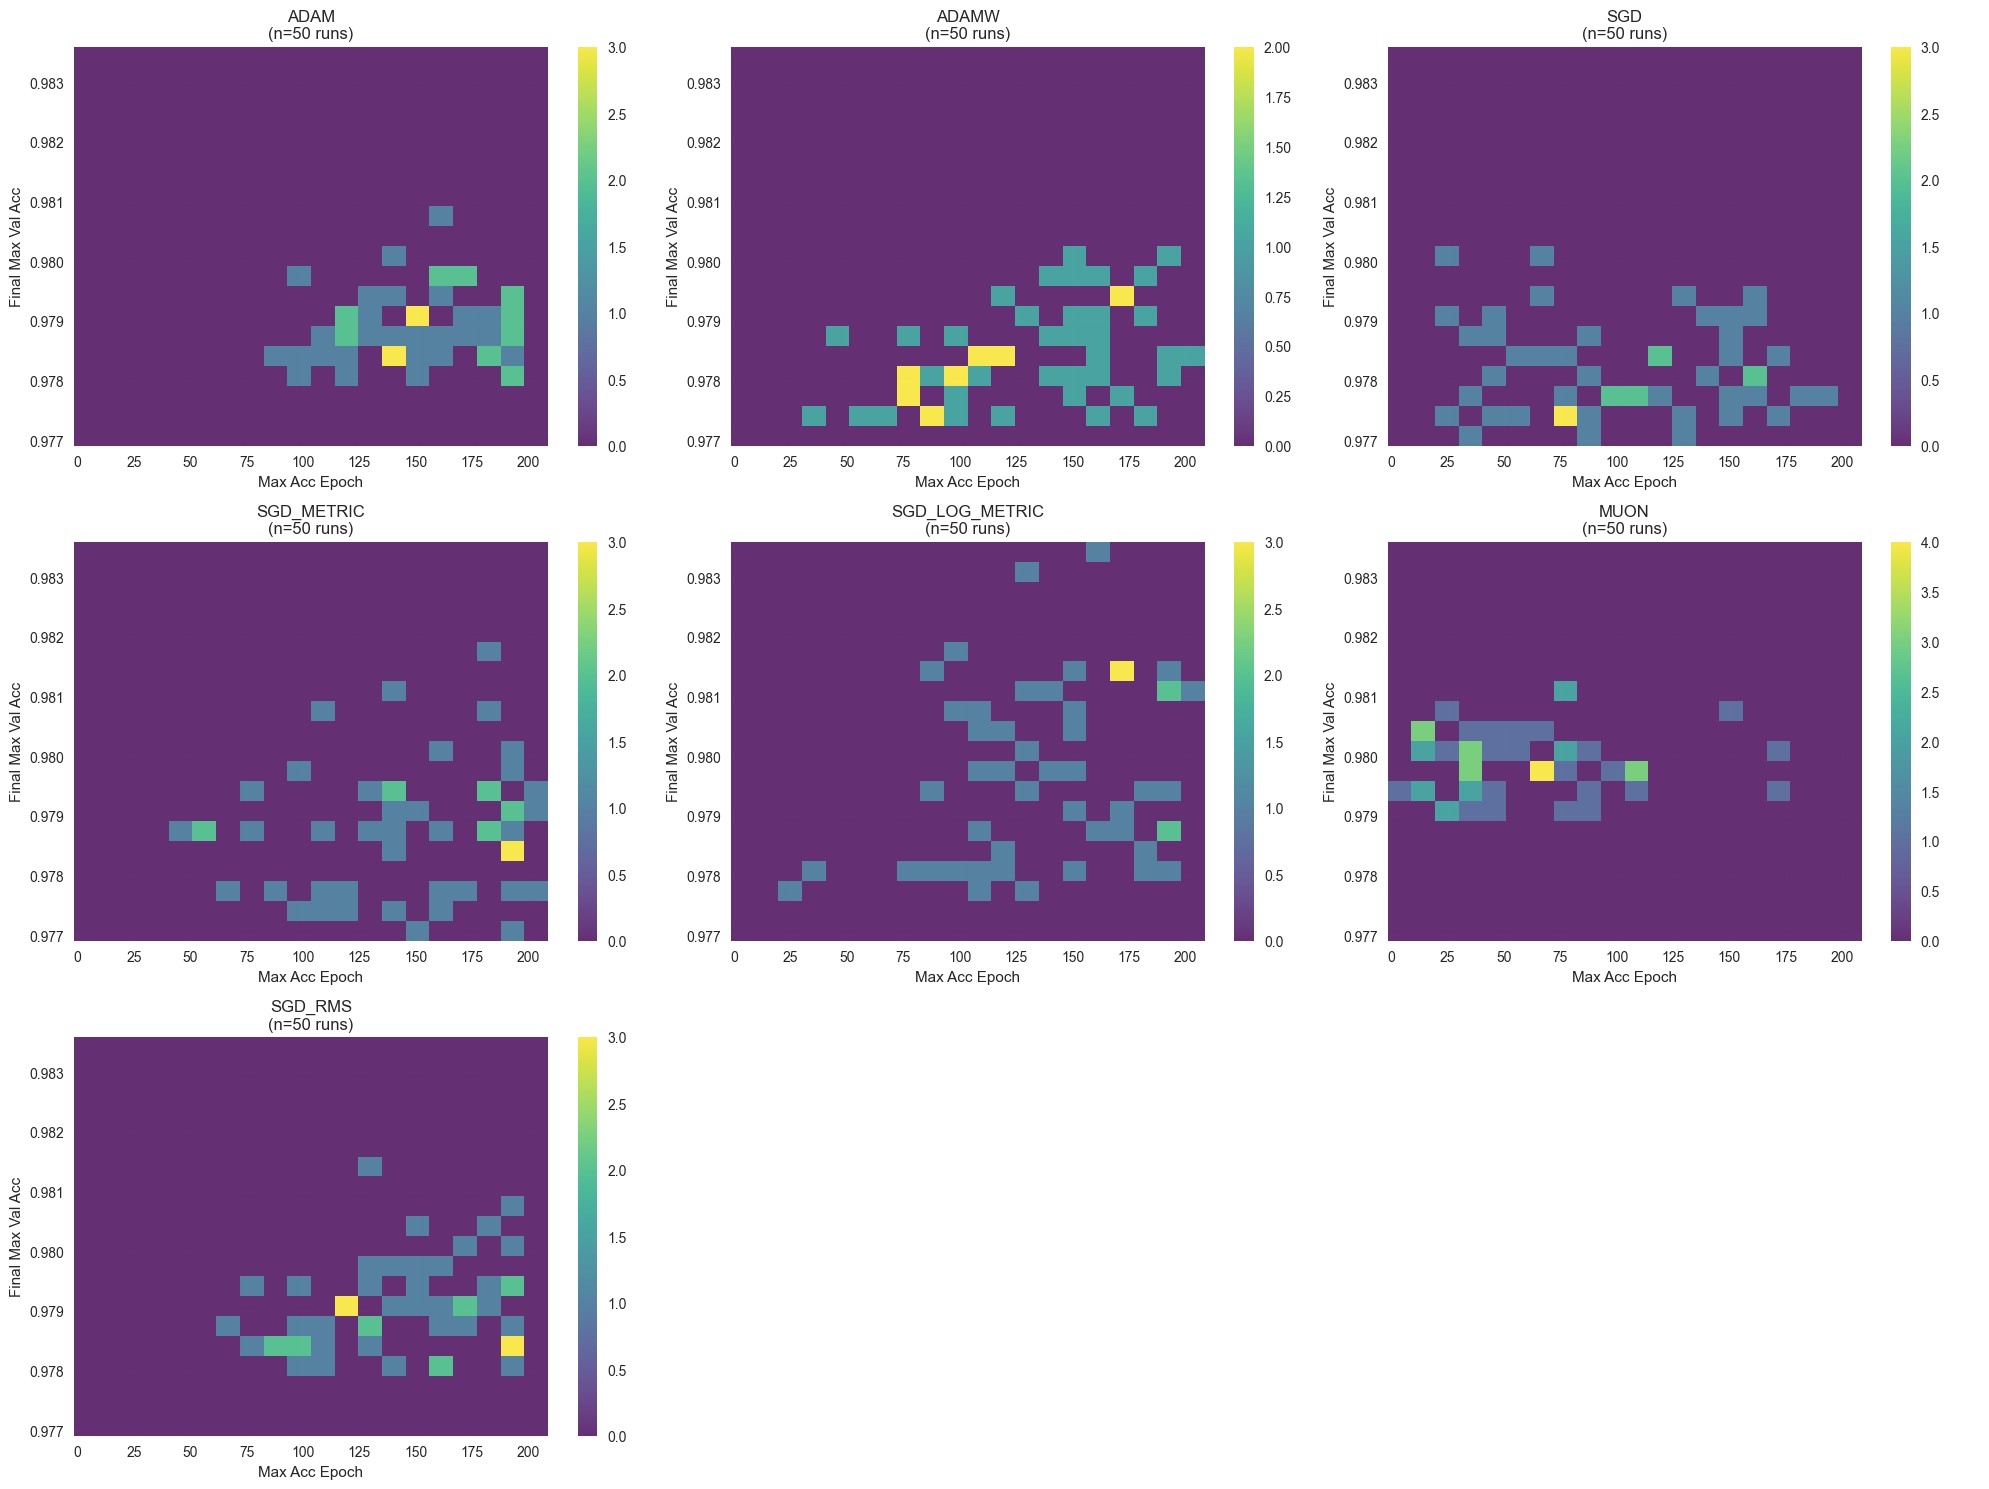

Summary Statistics: Max Val Acc vs Max Acc Epoch

ADAM:
  Runs with data: 50
  Max Val Acc - Mean: 0.978880, Std: 0.000567
  Max Acc Epoch - Mean: 151.4, Std: 30.4
  Best Max Val Acc: 0.980686 at epoch 157

ADAMW:
  Runs with data: 50
  Max Val Acc - Mean: 0.978440, Std: 0.000772
  Max Acc Epoch - Mean: 128.0, Std: 42.6
  Best Max Val Acc: 0.980252 at epoch 198

SGD:
  Runs with data: 50
  Max Val Acc - Mean: 0.978186, Std: 0.000744
  Max Acc Epoch - Mean: 102.9, Std: 48.9
  Best Max Val Acc: 0.980252 at epoch 28

SGD_METRIC:
  Runs with data: 50
  Max Val Acc - Mean: 0.978748, Std: 0.001023
  Max Acc Epoch - Mean: 146.9, Std: 44.2
  Best Max Val Acc: 0.981662 at epoch 183

SGD_LOG_METRIC:
  Runs with data: 50
  Max Val Acc - Mean: 0.979750, Std: 0.001462
  Max Acc Epoch - Mean: 138.8, Std: 42.2
  Best Max Val Acc: 0.983290 at epoch 159

MUON:
  Runs with data: 50
  Max Val Acc - Mean: 0.979844, Std: 0.000545
  Max Acc Epoch - Mean: 58.5, Std: 39.8
  Best Max Val Acc: 0.981120 at epoch

In [4]:
# Create 2D histograms for each optimizer showing final_max_val_acc vs final_max_acc_epoch
# with normalized axes for easier comparison
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

# First pass: collect global min/max values for consistent scaling
all_max_val_accs = []
all_max_acc_epochs = []

for optimizer in OPTIMISERS:
    if optimizer in best_50_runs:
        for run in best_50_runs[optimizer]:
            max_val_acc = run.summary.get('max_val_acc', None)
            max_acc_epoch = run.summary.get('max_acc_epoch', None)
            
            if max_val_acc is not None and max_acc_epoch is not None:
                all_max_val_accs.append(max_val_acc)
                all_max_acc_epochs.append(max_acc_epoch)

# Calculate global ranges for consistent axes
if all_max_val_accs:
    global_acc_min = min(all_max_val_accs)
    global_acc_max = max(all_max_val_accs)
    global_epoch_min = min(all_max_acc_epochs)
    global_epoch_max = max(all_max_acc_epochs)
    
    # Add some padding
    acc_range = global_acc_max - global_acc_min
    epoch_range = global_epoch_max - global_epoch_min
    
    acc_bins = np.linspace(global_acc_min - acc_range * 0.05, global_acc_max + acc_range * 0.05, 21)
    epoch_bins = np.linspace(global_epoch_min - epoch_range * 0.05, global_epoch_max + epoch_range * 0.05, 21)

# Second pass: create histograms with consistent bins
for i, optimizer in enumerate(OPTIMISERS):
    if optimizer in best_50_runs:
        # Collect data from the best 50 runs
        max_val_accs = []
        max_acc_epochs = []
        
        for run in best_50_runs[optimizer]:
            max_val_acc = run.summary.get('max_val_acc', None)
            max_acc_epoch = run.summary.get('max_acc_epoch', None)
            
            if max_val_acc is not None and max_acc_epoch is not None:
                max_val_accs.append(max_val_acc)
                max_acc_epochs.append(max_acc_epoch)
        
        if len(max_val_accs) > 0:
            # Create 2D histogram with consistent bins
            h = axes[i].hist2d(max_acc_epochs, max_val_accs, 
                              bins=[epoch_bins, acc_bins], 
                              cmap='viridis', alpha=0.8)
            
            # Add colorbar
            plt.colorbar(h[3], ax=axes[i])
            
            # Set title and labels
            axes[i].set_title(f'{optimizer.upper()}\n(n={len(max_val_accs)} runs)')
            axes[i].set_xlabel('Max Acc Epoch')
            axes[i].set_ylabel('Final Max Val Acc')
            axes[i].grid(True, alpha=0.3)
            
            # Set consistent axis limits
            axes[i].set_xlim(global_epoch_min - epoch_range * 0.05, global_epoch_max + epoch_range * 0.05)
            axes[i].set_ylim(global_acc_min - acc_range * 0.05, global_acc_max + acc_range * 0.05)
        else:
            axes[i].text(0.5, 0.5, f'No data for {optimizer}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{optimizer.upper()}\n(No data)')

# Hide any unused subplots
for j in range(len(OPTIMISERS), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Create a summary statistics table
print("Summary Statistics: Max Val Acc vs Max Acc Epoch")
print("=" * 80)

for optimizer in OPTIMISERS:
    if optimizer in best_50_runs:
        max_val_accs = []
        max_acc_epochs = []

        for run in best_50_runs[optimizer]:
            max_val_acc = run.summary.get('max_val_acc', None)
            max_acc_epoch = run.summary.get('max_acc_epoch', None)
            
            if max_val_acc is not None and max_acc_epoch is not None:
                max_val_accs.append(max_val_acc)
                max_acc_epochs.append(max_acc_epoch)
        
        if len(max_val_accs) > 0:
            print(f"\n{optimizer.upper()}:")
            print(f"  Runs with data: {len(max_val_accs)}")
            print(f"  Max Val Acc - Mean: {np.mean(max_val_accs):.6f}, Std: {np.std(max_val_accs):.6f}")
            print(f"  Max Acc Epoch - Mean: {np.mean(max_acc_epochs):.1f}, Std: {np.std(max_acc_epochs):.1f}")
            print(f"  Best Max Val Acc: {np.max(max_val_accs):.6f} at epoch {max_acc_epochs[np.argmax(max_val_accs)]}")


In [5]:
# Collect data for all optimizers
optimizer_data = {}

for optimizer, run in best_runs.items():
    print(f"Processing {optimizer}...")
    
    # Get history data
    history = run.scan_history()
    
    # Collect data
    epochs = []
    train_accs = []
    test_accs = []
    runtimes = []
    
    for row in history:
        if 'epoch' in row and row['epoch'] is not None:
            epochs.append(row['epoch'])
            train_accs.append(row.get('train_acc', None))
            test_accs.append(row.get('test_acc', None))
            runtimes.append(row.get('train_time_seconds', None))
    first_estimated_runtime = (runtimes[0] -  runtimes[-1])/(len(runtimes) - 1) if len(runtimes) > 1 else 0
    runtimes = [-rt+runtimes[0] + first_estimated_runtime for rt in runtimes if rt is not None]
    
    # Get start time for wall-time calculation
    start_time = runtimes[0] if runtimes else 0
    wall_times = [rt - start_time for rt in runtimes]

    # Sample every sample_count epoch plus the last epoch
    sample_count = 1
    valid_indices = list(range(0, len(epochs), sample_count))
    if len(epochs) - 1 not in valid_indices:
        valid_indices.append(len(epochs) - 1)
    
    # Filter data and keep accuracies as they are
    epochs_filtered = np.array([epochs[i] for i in valid_indices])
    train_accs_filtered = np.array([train_accs[i] for i in valid_indices if train_accs[i] is not None])
    test_accs_filtered = np.array([test_accs[i] for i in valid_indices if test_accs[i] is not None])
    wall_times_filtered = np.array([wall_times[i] for i in valid_indices])
    
    # Ensure all arrays have the same length
    min_length = min(len(epochs_filtered), len(train_accs_filtered), len(test_accs_filtered), len(wall_times_filtered))
    
    optimizer_data[optimizer] = {
        'epochs': epochs_filtered[:min_length],
        'train_accs': train_accs_filtered[:min_length],
        'test_accs': test_accs_filtered[:min_length],
        'wall_times': wall_times_filtered[:min_length]
    }

print(f"\nProcessed data for {len(optimizer_data)} optimizers")

Processing adam...
Processing adamw...
Processing sgd...
Processing sgd_metric...
Processing sgd_log_metric...
Processing muon...
Processing sgd_rms...

Processed data for 7 optimizers


Time to reach best accuracy for each optimizer's best run:
ADAM           :    16.95s at epoch 157 (test_acc: 0.980686)
ADAMW          :    21.31s at epoch 198 (test_acc: 0.980252)
SGD            :     2.81s at epoch  28 (test_acc: 0.980252)
SGD_METRIC     :    18.94s at epoch 183 (test_acc: 0.981662)
SGD_LOG_METRIC :    16.64s at epoch 159 (test_acc: 0.983290)
MUON           :    10.48s at epoch  81 (test_acc: 0.981120)
SGD_RMS        :    14.54s at epoch 133 (test_acc: 0.981554)


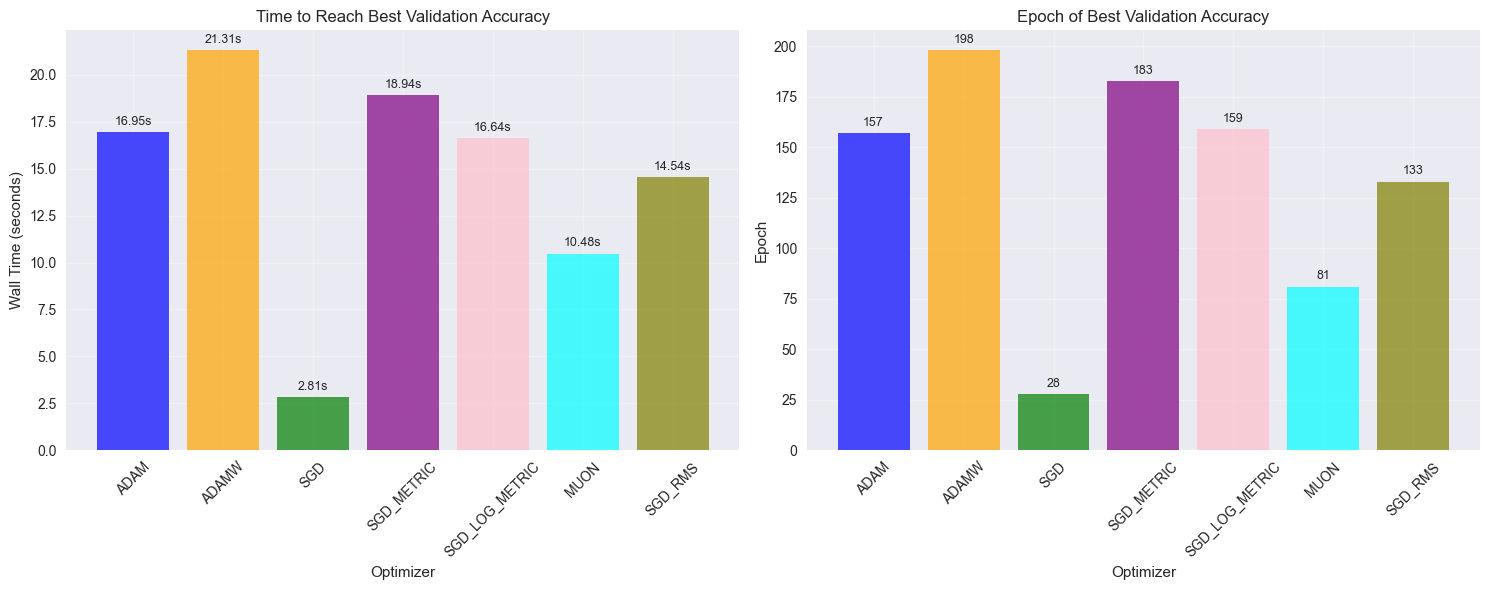


Summary Statistics:
Fastest to best accuracy: SGD (2.81s)
Slowest to best accuracy: ADAMW (21.31s)
Earliest epoch: SGD (epoch 28)
Latest epoch: ADAMW (epoch 198)


In [6]:
optimizer_colors = {
    'sgd_rms': 'olive',
    'adam': 'blue',
    'adamw': 'orange',
    'sgd': 'green',
    'sgd_metric': 'purple',
    'sgd_log_metric': 'pink',
    'muon': 'cyan'
}

# Extract time to reach best accuracy for each optimizer's best run
best_times = {}

print("Time to reach best accuracy for each optimizer's best run:")
print("=" * 70)

for optimizer in OPTIMISERS:
    if optimizer in best_runs and optimizer in optimizer_data:
        # Get the max_accuracy_epoch from the best run summary
        best_run = best_runs[optimizer]
        max_accuracy_epoch = best_run.summary.get('max_acc_epoch', None)

        if max_accuracy_epoch is not None:
            # Find the corresponding wall time from optimizer_data
            data = optimizer_data[optimizer]

            # Find the index where epoch equals max_accuracy_epoch
            epoch_indices = np.where(data['epochs'] == max_accuracy_epoch)[0]
            
            if len(epoch_indices) > 0:
                epoch_idx = epoch_indices[0]
                wall_time_to_best = data['wall_times'][epoch_idx]
                test_acc_best = data['test_accs'][epoch_idx]

                best_times[optimizer] = {
                    'epoch': max_accuracy_epoch,
                    'wall_time': wall_time_to_best,
                    'test_acc': test_acc_best
                }

                print(f"{optimizer.upper():<15}: {wall_time_to_best:>8.2f}s at epoch {max_accuracy_epoch:>3d} (test_acc: {test_acc_best:.6f})")
            else:
                print(f"{optimizer.upper():<15}: Epoch {max_accuracy_epoch} not found in data")
        else:
            print(f"{optimizer.upper():<15}: No max_accuracy_epoch found")

# Create a comparison plot
if best_times:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    optimizers_list = list(best_times.keys())
    wall_times_list = [best_times[opt]['wall_time'] for opt in optimizers_list]
    epochs_list = [best_times[opt]['epoch'] for opt in optimizers_list]
    colors_list = [optimizer_colors[opt] for opt in optimizers_list]
    
    # Plot wall times
    bars1 = ax1.bar(range(len(optimizers_list)), wall_times_list, color=colors_list, alpha=0.7)
    ax1.set_xlabel('Optimizer')
    ax1.set_ylabel('Wall Time (seconds)')
    ax1.set_title('Time to Reach Best Validation Accuracy')
    ax1.set_xticks(range(len(optimizers_list)))
    ax1.set_xticklabels([opt.upper() for opt in optimizers_list], rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    # Plot epochs
    bars2 = ax2.bar(range(len(optimizers_list)), epochs_list, color=colors_list, alpha=0.7)
    ax2.set_xlabel('Optimizer')
    ax2.set_ylabel('Epoch')
    ax2.set_title('Epoch of Best Validation Accuracy')
    ax2.set_xticks(range(len(optimizers_list)))
    ax2.set_xticklabels([opt.upper() for opt in optimizers_list], rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nSummary Statistics:")
    print(f"Fastest to best accuracy: {min(best_times.items(), key=lambda x: x[1]['wall_time'])[0].upper()} ({min(wall_times_list):.2f}s)")
    print(f"Slowest to best accuracy: {max(best_times.items(), key=lambda x: x[1]['wall_time'])[0].upper()} ({max(wall_times_list):.2f}s)")
    print(f"Earliest epoch: {min(best_times.items(), key=lambda x: x[1]['epoch'])[0].upper()} (epoch {min(epochs_list)})")
    print(f"Latest epoch: {max(best_times.items(), key=lambda x: x[1]['epoch'])[0].upper()} (epoch {max(epochs_list)})")

# Train and validation loss curves

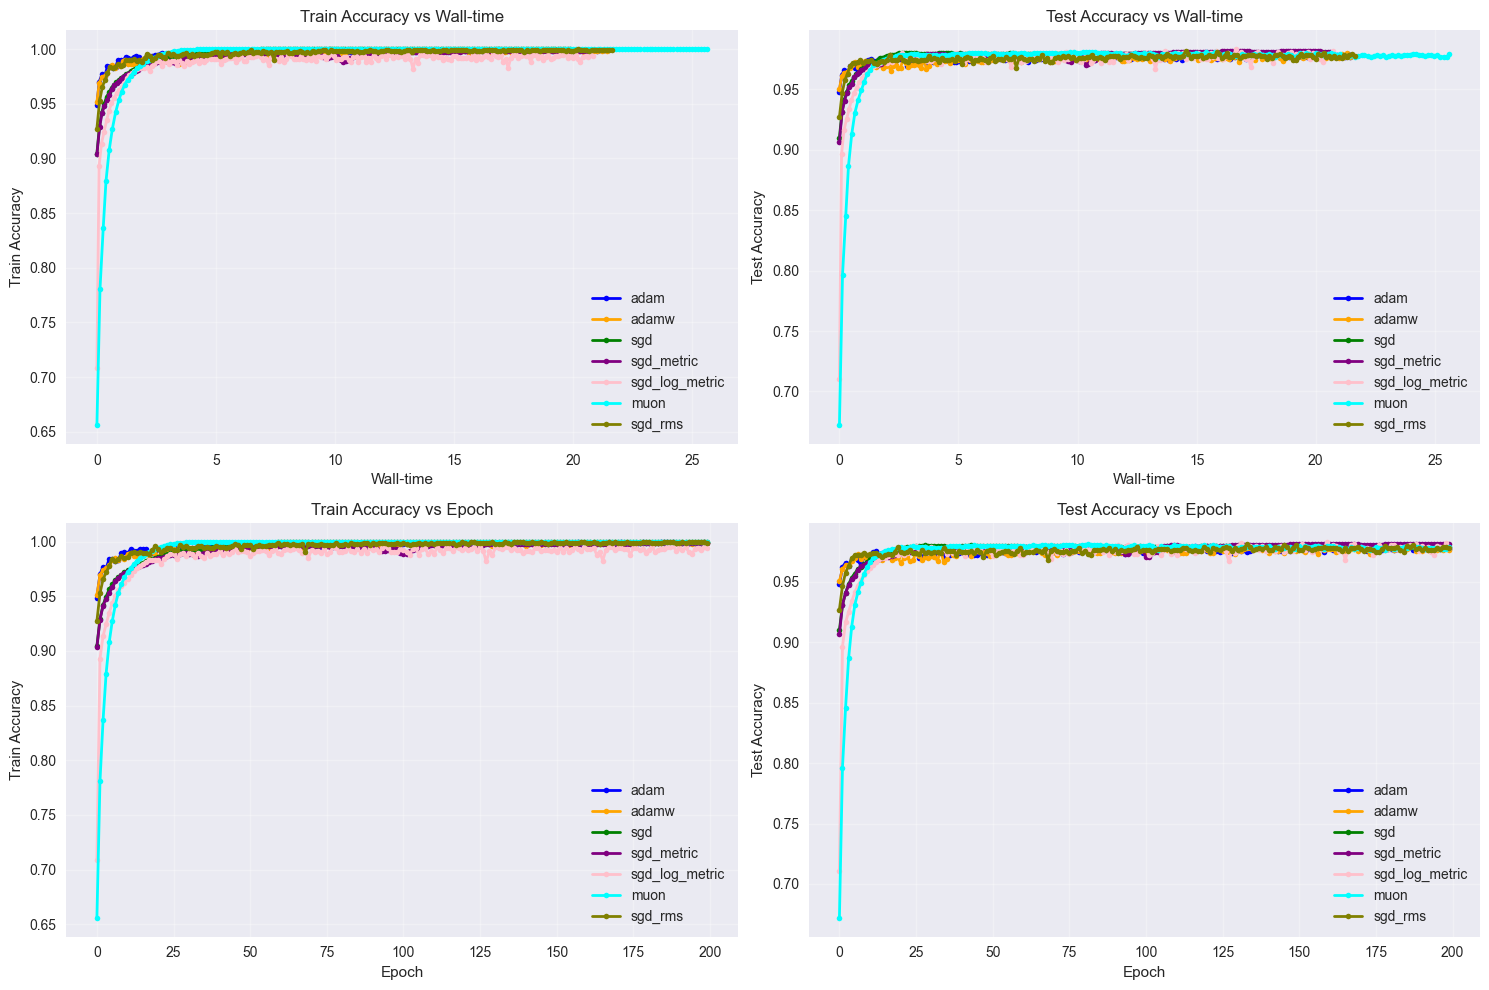

In [7]:
optimizer_colors = {
    'sgd_rms': 'olive',
    'adam': 'blue',
    'adamw': 'orange',
    'sgd': 'green',
    'sgd_metric': 'purple',
    'sgd_log_metric': 'pink',
    'muon': 'cyan'
}

# Create subplots for all optimizers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for optimizer, data in optimizer_data.items():
    color = optimizer_colors[optimizer]
    
    # Plot Train Accuracy vs Wall-time
    axes[0, 0].plot(data['wall_times'], data['train_accs'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Test Accuracy vs Wall-time
    axes[0, 1].plot(data['wall_times'], data['test_accs'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Train Accuracy vs Epoch
    axes[1, 0].plot(data['epochs'], data['train_accs'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Test Accuracy vs Epoch
    axes[1, 1].plot(data['epochs'], data['test_accs'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)

# Set titles and labels
axes[0, 0].set_title('Train Accuracy vs Wall-time')
axes[0, 0].set_xlabel('Wall-time')
axes[0, 0].set_ylabel('Train Accuracy')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].set_title('Test Accuracy vs Wall-time')
axes[0, 1].set_xlabel('Wall-time')
axes[0, 1].set_ylabel('Test Accuracy')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].set_title('Train Accuracy vs Epoch')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Train Accuracy')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].set_title('Test Accuracy vs Epoch')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Test Accuracy')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

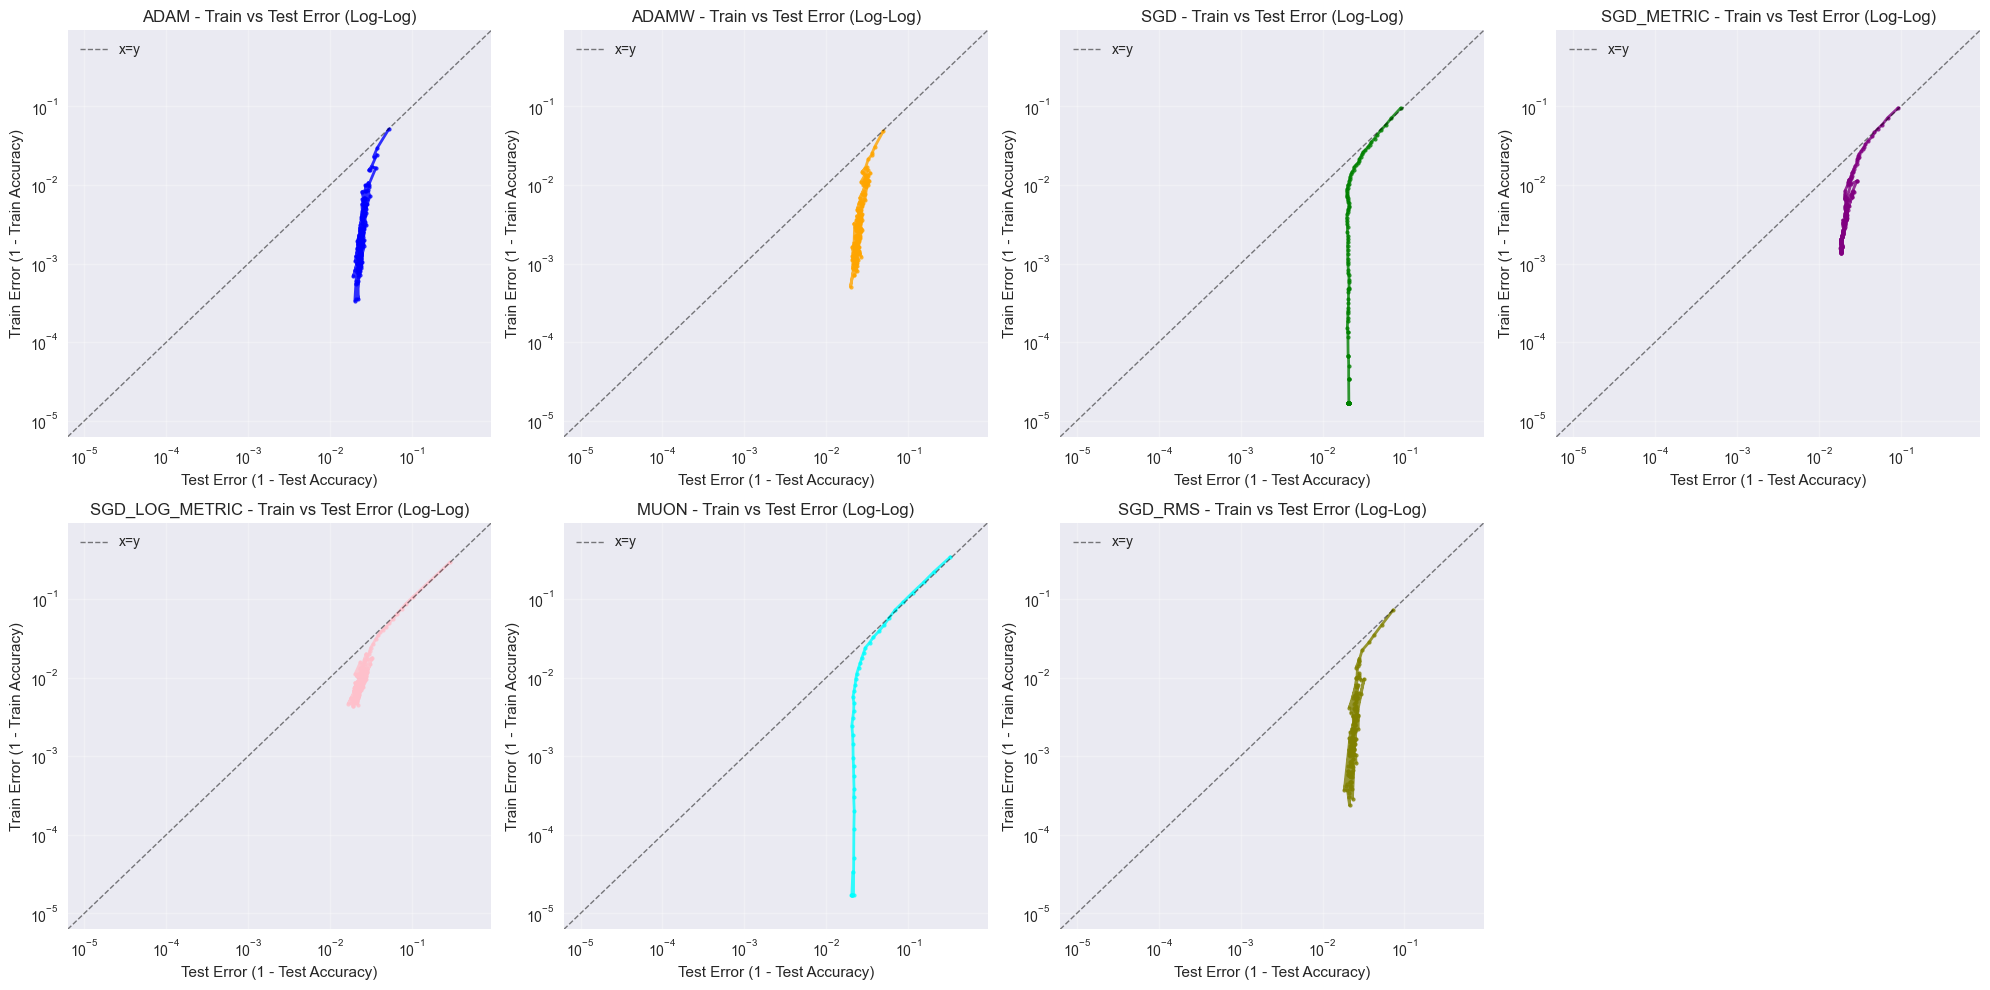

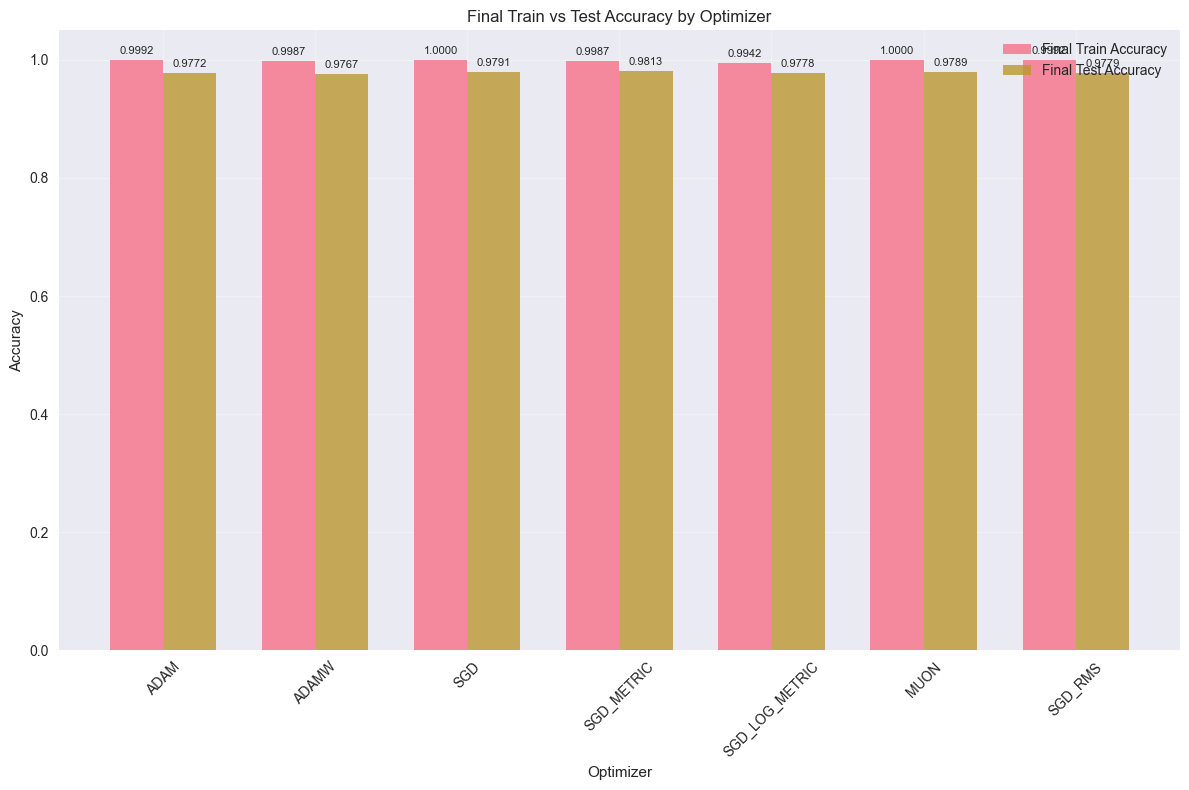

In [8]:
# Create individual plots for each optimizer showing training vs test accuracy on log-log scale
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Changed to 2x4 to accommodate 7 optimizers
axes = axes.flatten()

# First pass: collect all error values to determine global limits
all_train_errors = []
all_test_errors = []

for optimizer, data in optimizer_data.items():
    train_error = 1 - data['train_accs']
    test_error = 1 - data['test_accs']
    
    # Filter out zero errors
    valid_mask = (train_error > 0) & (test_error > 0)
    train_error_filtered = train_error[valid_mask]
    test_error_filtered = test_error[valid_mask]
    
    if len(train_error_filtered) > 0:
        all_train_errors.extend(train_error_filtered)
    if len(test_error_filtered) > 0:
        all_test_errors.extend(test_error_filtered)

# Calculate global limits
if all_train_errors and all_test_errors:
    min_error = min(min(all_train_errors), min(all_test_errors))
    max_error = max(max(all_train_errors), max(all_test_errors))
    
    # Add some padding
    log_min = np.log10(min_error)
    log_max = np.log10(max_error)
    log_range = log_max - log_min
    
    global_min = 10**(log_min - log_range * 0.1)
    global_max = 10**(log_max + log_range * 0.1)

# Second pass: create plots with consistent limits
for i, (optimizer, data) in enumerate(optimizer_data.items()):
    color = optimizer_colors[optimizer]
    
    # Convert accuracies to log scale (1 - accuracy for better visualization)
    train_error = 1 - data['train_accs']
    test_error = 1 - data['test_accs']
    
    # Filter out zero errors to avoid log(0)
    valid_mask = (train_error > 0) & (test_error > 0)
    train_error_filtered = train_error[valid_mask]
    test_error_filtered = test_error[valid_mask]
    
    # Plot test error (x-axis) vs train error (y-axis) on log-log scale
    axes[i].loglog(test_error_filtered, train_error_filtered, 'o-', 
                   linewidth=2, markersize=3, color=color, alpha=0.8)
    
    # Add x=y line (perfect correlation line)
    axes[i].loglog([global_min, global_max], [global_min, global_max], 'k--', alpha=0.5, linewidth=1, label='x=y')
    
    # Set consistent limits
    axes[i].set_xlim(global_min, global_max)
    axes[i].set_ylim(global_min, global_max)
    
    # Set title and labels
    axes[i].set_title(f'{optimizer.upper()} - Train vs Test Error (Log-Log)')
    axes[i].set_xlabel('Test Error (1 - Test Accuracy)')
    axes[i].set_ylabel('Train Error (1 - Train Accuracy)')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

# Hide the 8th subplot since we only have 7 optimizers
axes[7].set_visible(False)

plt.tight_layout()
plt.show()

# Create a summary plot comparing final accuracies
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

optimizers_list = list(optimizer_data.keys())
train_final = [optimizer_data[opt]['train_accs'][-1] for opt in optimizers_list]
test_final = [optimizer_data[opt]['test_accs'][-1] for opt in optimizers_list]

x_pos = np.arange(len(optimizers_list))
width = 0.35

bars1 = ax.bar(x_pos - width/2, train_final, width, label='Final Train Accuracy', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, test_final, width, label='Final Test Accuracy', alpha=0.8)

ax.set_xlabel('Optimizer')
ax.set_ylabel('Accuracy')
ax.set_title('Final Train vs Test Accuracy by Optimizer')
ax.set_xticks(x_pos)
ax.set_xticklabels([opt.upper() for opt in optimizers_list], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


# Speedtests

In [9]:
# Calculate speedrun times for each target
speedrun_results = {}

for optimizer, data in optimizer_data.items():
    speedrun_results[optimizer] = {}
    
    for target in SPEEDRUN_TARGETS:
        # Find the first epoch where test accuracy goes above the target
        above_target_indices = np.where(data['test_accs'] >= target)[0]
        
        if len(above_target_indices) > 0:
            first_index = above_target_indices[0]
            speedrun_results[optimizer][target] = {
                'epoch': data['epochs'][first_index],
                'wall_time': data['wall_times'][first_index],
                'test_acc': data['test_accs'][first_index]
            }
        else:
            speedrun_results[optimizer][target] = {
                'epoch': None,
                'wall_time': None,
                'test_acc': None
            }

# Create a summary table
print("Speedrun Results: Time to reach target test accuracy")
print("=" * 80)

# Create header
header = f"{'Optimizer':<15}"
for target in SPEEDRUN_TARGETS:
    header += f"{target:<8}"
print(header)
print("-" * 80)

# Print results for each optimizer
for optimizer in OPTIMISERS:
    if optimizer in speedrun_results:
        row = f"{optimizer:<15}"
        for target in SPEEDRUN_TARGETS:
            result = speedrun_results[optimizer][target]
            if result['wall_time'] is not None:
                row += f"{result['wall_time']:<8.1f}"
            else:
                row += f"{'--':<8}"
        print(row)

print("\nNote: Times shown are wall-clock seconds to first achieve target test accuracy")
print("'--' indicates the target was never reached during training")

# Create a more detailed table with epochs
print("\n\nDetailed Speedrun Results")
print("=" * 100)

for target in SPEEDRUN_TARGETS[:5]:  # Show first 5 targets for detail
    print(f"\nTarget Test Accuracy: {target}")
    print(f"{'Optimizer':<15} {'Epoch':<8} {'Wall Time (s)':<15} {'Actual Acc':<12}")
    print("-" * 50)
    
    for optimizer in OPTIMISERS:
        if optimizer in speedrun_results:
            result = speedrun_results[optimizer][target]
            if result['epoch'] is not None:
                print(f"{optimizer:<15} {result['epoch']:<8} {result['wall_time']:<15.2f} {result['test_acc']:<12.6f}")
            else:
                print(f"{optimizer:<15} {'--':<8} {'--':<15} {'--':<12}")

Speedrun Results: Time to reach target test accuracy
Optimizer      0.9     0.91    0.92    0.93    0.94    0.95    0.96    0.97    0.98    0.99    
--------------------------------------------------------------------------------
adam           0.0     0.0     0.0     0.0     0.0     0.1     0.1     0.6     17.0    --      
adamw          0.0     0.0     0.0     0.0     0.0     0.0     0.1     0.6     21.3    --      
sgd            0.0     0.0     0.1     0.1     0.2     0.4     0.6     1.2     2.7     --      
sgd_metric     0.0     0.1     0.1     0.1     0.2     0.4     0.6     1.4     11.2    --      
sgd_log_metric 0.2     0.2     0.3     0.4     0.5     0.7     1.0     1.6     4.9     --      
muon           0.5     0.5     0.6     0.6     0.8     1.0     1.2     1.6     5.6     --      
sgd_rms        0.0     0.0     0.0     0.1     0.1     0.2     0.3     0.6     14.5    --      

Note: Times shown are wall-clock seconds to first achieve target test accuracy
'--' indicates the

In [10]:
# Print hyperparameters for the best runs
print("Hyperparameters for Best Runs")
print("=" * 60)

for optimizer, run in best_runs.items():
    print(f"\n{optimizer.upper()}:")
    print(f"Run name: {run.name}")
    print(f"Config:")
    
    # Get the run's config
    config = run.config
    
    # Print relevant hyperparameters
    for key, value in config.items():
        if key not in ['_wandb', 'wandb_version']:  # Skip internal wandb keys
            print(f"  {key}: {value}")
    
    # Get final metrics
    summary = run.summary
    if 'final_test_acc' in summary:
        print(f"Final test accuracy: {summary['final_test_acc']:.6f}")
    if 'max_val_acc' in summary:
        print(f"Max validation accuracy: {summary['max_val_acc']:.6f}")
    
    print("-" * 40)

Hyperparameters for Best Runs

ADAM:
Run name: copper-sweep-497
Config:
  eps: 1e-08
  beta1: 0.8375455338479524
  beta2: 0.9628536201795213
  n_epochs: 200
  batch_size: 1024
  learning_rate: 0.009377619174366894
Final test accuracy: 0.977214
Max validation accuracy: 0.980686
----------------------------------------

ADAMW:
Run name: sage-sweep-134
Config:
  eps: 1e-08
  beta1: 0.893271837956604
  beta2: 0.982027411566941
  n_epochs: 200
  batch_size: 1024
  weight_decay: 2.182360929898813e-06
  learning_rate: 0.012343409756158172
Final test accuracy: 0.976671
Max validation accuracy: 0.980252
----------------------------------------

SGD:
Run name: faithful-sweep-164
Config:
  momentum: 0.40126305777764737
  n_epochs: 200
  batch_size: 1024
  learning_rate: 0.3171425659569204
Final test accuracy: 0.979058
Max validation accuracy: 0.980252
----------------------------------------

SGD_METRIC:
Run name: vivid-sweep-212
Config:
  xi: 7.429900238145742e-05
  beta: 0.8892935732449405
  mo

In [11]:
# Create a DataFrame with best hyperparameters for each optimizer
hyperparams_data = []

for optimizer, run in best_runs.items():
    config = run.config
    
    # Create a row with optimizer name and all hyperparameters
    row = {'optimizer': optimizer}
    
    # Add all config parameters except internal wandb keys
    for key, value in config.items():
        if key not in ['_wandb', 'wandb_version']:
            row[key] = value
    
    # Add final performance metrics (using correct MNIST classification metrics)
    summary = run.summary
    row['final_test_acc'] = summary.get('final_test_acc', None)
    row['final_train_acc'] = summary.get('final_train_acc', None)
    row['max_val_acc'] = summary.get('max_val_acc', None)
    row['run_name'] = run.name
    
    hyperparams_data.append(row)

# Convert to DataFrame
hyperparams_df = pd.DataFrame(hyperparams_data)

# Save to CSV with MNIST in filename
filename = f'best_hyperparameters_MNIST_run_{RUN_INDEX}.csv'
hyperparams_df.to_csv(filename, index=False)

print(f"Best hyperparameters saved to '{filename}'")
print(f"Shape: {hyperparams_df.shape}")
print("\nColumns in the dataset:")
print(hyperparams_df.columns.tolist())
print("\nFirst few rows:")
print(hyperparams_df.head())

Best hyperparameters saved to 'best_hyperparameters_MNIST_run_1.csv'
Shape: (7, 18)

Columns in the dataset:
['optimizer', 'eps', 'beta1', 'beta2', 'n_epochs', 'batch_size', 'learning_rate', 'final_test_acc', 'final_train_acc', 'max_val_acc', 'run_name', 'weight_decay', 'momentum', 'xi', 'beta', 'adam_b1', 'adam_b2', 'beta_rms']

First few rows:
        optimizer           eps     beta1     beta2  n_epochs  batch_size  \
0            adam  1.000000e-08  0.837546  0.962854       200        1024   
1           adamw  1.000000e-08  0.893272  0.982027       200        1024   
2             sgd           NaN       NaN       NaN       200        1024   
3      sgd_metric           NaN       NaN       NaN       200        1024   
4  sgd_log_metric           NaN       NaN       NaN       200        1024   

   learning_rate  final_test_acc  final_train_acc  max_val_acc  \
0       0.009378        0.977214         0.999242     0.980686   
1       0.012343        0.976671         0.998670     0.9